<a href="https://colab.research.google.com/github/nestorbalcazar/nestorbalcazar.github.io/blob/master/NumMethods_Sphere1D_SteadyImplicit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GS/SOR (BC T_face≈T_P): it=15087, T_min=383.333 K, T_max=424.583 K
Error vs analítica 'real' (referencia): L_inf = 4.156e-01 K,   L2 = 4.156e-01 K

Balance energético con tu BC:
  Q_gen      = 2.094395e+03 W
  Q_conv_num = 2.094395e+03 W
  |Q_gen - Q_conv_num| / Q_gen = 3.510e-12


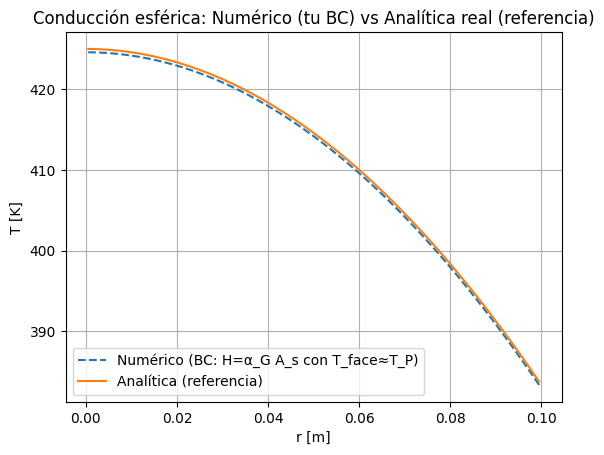

In [25]:
# --- Conducción radial en esfera: FVM + GS/SOR ---
# PDE (estacionaria, λ,qdot constantes):
#   0 = (1/r^2) d/dr( λ r^2 dT/dr ) + qdot
# BCs:
#   r=0   : simetría (dT/dr=0)
#   r=Re  : CONDICIÓN PEDIDA -> convección directa en el centroide del último VC:
#           Q_conv = α_G * A_s * (T_P - T_G), con T_face ≈ T_P
#
# Nota: esta BC elimina la resistencia conductiva centroide-superficie, por lo que
#       NO coincide exactamente con la solución analítica "real" (Robin en r=Re).
#       Usamos la analítica real como referencia para ver el sesgo.

import numpy as np
import matplotlib.pyplot as plt

# ---------- Parámetros físicos ----------
Re      = 0.10        # [m] radio externo
lam     = 20.0        # [W/(m·K)] conductividad térmica
qdot    = 5.0e5       # [W/m^3] fuente volumétrica
alpha_G = 200.0       # [W/(m^2·K)] coeficiente de convección
T_G     = 300.0       # [K] temperatura del gas
A_s     = 4.0*np.pi*Re**2   # área superficial esférica

# ---------- Mallado ----------
N   = 100
r_f = np.linspace(0.0, Re, N+1)           # radios en caras
r_c = 0.5*(r_f[:-1] + r_f[1:])            # radios en centros (centroides VC)
Aw  = 4.0*np.pi*(r_f[:-1]**2)             # área cara oeste de VC i (en r_f[i])
Ae  = 4.0*np.pi*(r_f[1:]**2)              # área cara este  de VC i (en r_f[i+1])
Vp  = (4.0*np.pi/3.0)*(r_f[1:]**3 - r_f[:-1]**3)  # volumen VC i

# Distancias entre centroides (NO centro-cara)
# rW = r_c[i-1], rP = r_c[i], rE = r_c[i+1]
dWP = np.zeros(N)          # Δr_WP = rP - rW
dPE = np.zeros(N)          # Δr_PE = rE - rP
dWP[1:]   = r_c[1:] - r_c[:-1]
dPE[:-1]  = r_c[1:] - r_c[:-1]
# En i=0 no hay vecino oeste; en i=N-1 no hay vecino este.

# ---------- Ensamblaje: aP*T_P = aE*T_E + aW*T_W + bP ----------
aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
SU = qdot * Vp   # S_U = qdot * Vp (calentamiento -> signo positivo)

for i in range(N):
    # Cara oeste (difusión hacia el interior) con distancia CENTRO-CENTRO
    if i == 0:
        Dw = 0.0                       # simetría en el centro
    else:
        Dw = lam * Aw[i] / (dWP[i] + 1e-300)   # área en la CARA, distancia entre centroides

    # Cara este
    if i == N-1:
        # Frontera CONVECTIVA pedida: T_face ≈ T_P (sin resistencia serie)
        H  = alpha_G * A_s            # coef. lumped en el centroide del último VC
        De = 0.0
        aW[i] = Dw
        aE[i] = 0.0
        aP[i] = Dw + H
        bP[i] = SU[i] + H * T_G
    else:
        # Difusión hacia el vecino este con distancia CENTRO-CENTRO
        De = lam * Ae[i] / (dPE[i] + 1e-300)
        aW[i] = Dw
        aE[i] = De
        aP[i] = Dw + De
        bP[i] = SU[i]

# ---------- Solver Gauss–Seidel / SOR ----------
def gauss_seidel(aW, aP, aE, bP, T0, itmax=300000, tol=1e-12, omega=1.6):
    T = T0.copy()
    N = len(T)
    for it in range(itmax):
        Told = T.copy()
        for i in range(N):
            TW = T[i-1] if i > 0     else 0.0
            TE = T[i+1] if i < N-1   else 0.0
            RHS = aE[i]*TE + aW[i]*TW + bP[i]
            T[i] = (1.0-omega)*T[i] + omega * RHS / (aP[i] + 1e-300)
        if np.max(np.abs(T - Told)) < tol:
            return T, it+1
    return T, itmax

T0 = np.full(N, T_G)
T_num, iters = gauss_seidel(aW, aP, aE, bP, T0, omega=1.75)
print(f"GS/SOR (BC T_face≈T_P): it={iters}, T_min={T_num.min():.3f} K, T_max={T_num.max():.3f} K")

# ---------- Analítica "real" (Robin en la superficie) como referencia ----------
def T_ana(r):
    # T(r) = T_G + (qdot/(3*alpha_G)) Re + (qdot/(6*lam)) (Re^2 - r^2)
    return T_G + (qdot/(3.0*alpha_G))*Re + (qdot/(6.0*lam))*(Re**2 - r**2)

T_ref = T_ana(r_c)
Linf  = np.max(np.abs(T_num - T_ref))
L2    = np.sqrt(np.mean((T_num - T_ref)**2))
print(f"Error vs analítica 'real' (referencia): L_inf = {Linf:.3e} K,   L2 = {L2:.3e} K")

# ---------- Balance energético (con tu BC) ----------
# Generación total
V_total   = (4.0*np.pi/3.0)*Re**3
Q_gen     = qdot * V_total
# Con tu BC, el flujo de salida en superficie es:
Q_conv_num = alpha_G * A_s * (T_num[-1] - T_G)    # porque T_face ≈ T_P último
print("\nBalance energético con tu BC:")
print(f"  Q_gen      = {Q_gen:.6e} W")
print(f"  Q_conv_num = {Q_conv_num:.6e} W")
print(f"  |Q_gen - Q_conv_num| / Q_gen = {abs(Q_gen - Q_conv_num)/abs(Q_gen):.3e}")

# ---------- Gráficas ----------
plt.figure()
plt.plot(r_c, T_num, '--', label='Numérico (BC: H=α_G A_s con T_face≈T_P)')
plt.plot(r_c, T_ref, '-', label='Analítica (referencia)')
plt.xlabel('r [m]'); plt.ylabel('T [K]'); plt.grid(True); plt.legend()
plt.title('Conducción esférica: Numérico (tu BC) vs Analítica real (referencia)')
plt.show()

[Tp] N=200: iters=70595, Tmin=383.333, Tmax=424.792
[Fe] N=200: iters=70956, Tmin=383.542, Tmax=425.000
L_inf (Tp) vs analítica: 0.20807291863752653
L_inf (Fe) vs analítica: 0.0002604155847052425
Orden observado (Tp) ≈ 0.996
Orden observado (Fe) ≈ 2.000


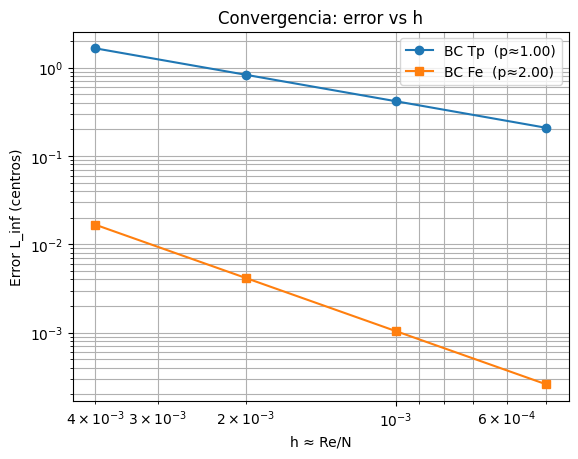

In [26]:
# --- Conducción radial en esfera: FVM + GS/SOR + Estudio de convergencia ---
# PDE (estacionaria, λ,qdot constantes):
#   0 = (1/r^2) d/dr( λ r^2 dT/dr ) + qdot
# BCs:
#   r=0   : simetría (dT/dr=0)
#   r=Re  : dos opciones
#           (1) BC "Tp": convección directa en el centroide del último VC: Q = α_G A_s (T_P - T_G)
#               (equivalente a usar T_face≈T_P)  -> 1er orden en la frontera
#           (2) BC "Fe": resistencia en serie centroide-superficie: Fe = A_s / (1/α_G + Δr/λ)
#               (Robin exacta discreta) -> 2º orden

import numpy as np
import matplotlib.pyplot as plt

# ---------- Parámetros físicos ----------
Re      = 0.10        # [m]
lam     = 20.0        # [W/(m·K)]
qdot    = 5.0e5       # [W/m^3]
alpha_G = 200.0       # [W/(m^2·K)]
T_G     = 300.0       # [K]

# ---------- Solución analítica (Robin real en r=Re) ----------
def T_ana(r):
    # T(r) = T_G + (qdot/(3*alpha_G)) Re + (qdot/(6*lam)) (Re^2 - r^2)
    return T_G + (qdot/(3.0*alpha_G))*Re + (qdot/(6.0*lam))*(Re**2 - r**2)

# ---------- Constructor de sistema y solución ----------
def solve_FVM(N, bc_type="Tp", omega=1.7, tol=1e-12, itmax=300000, verbose=False):
    """
    bc_type: "Tp" usa H=α_G A_s con T_face≈T_P (1er orden en frontera)
             "Fe" usa resistencia en serie Fe=A_s/(1/α + Δr/λ) (Robin exacta discreta)
    Devuelve: r_c, T_num, iters
    """
    # Mallado
    r_f = np.linspace(0.0, Re, N+1)              # caras
    r_c = 0.5*(r_f[:-1] + r_f[1:])               # centros
    Aw  = 4.0*np.pi*(r_f[:-1]**2)                # área cara w
    Ae  = 4.0*np.pi*(r_f[1:]**2)                 # área cara e
    Vp  = (4.0*np.pi/3.0)*(r_f[1:]**3 - r_f[:-1]**3)
    # distancias entre CENTROIDES
    dWP = np.zeros(N); dPE = np.zeros(N)
    dWP[1:]  = r_c[1:] - r_c[:-1]                # rP - rW
    dPE[:-1] = r_c[1:] - r_c[:-1]                # rE - rP
    A_s = 4.0*np.pi*Re**2

    # Ensamblaje
    aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
    SU = qdot * Vp

    for i in range(N):
        # oeste
        Dw = 0.0 if i == 0 else lam * Aw[i] / (dWP[i] + 1e-300)
        # este
        if i == N-1:
            if bc_type == "Tp":
                # convección "lumped" en el centroide
                H = alpha_G * A_s
                De = 0.0
                aW[i] = Dw; aE[i] = 0.0; aP[i] = Dw + H; bP[i] = SU[i] + H*T_G
            elif bc_type == "Fe":
                # resistencia en serie centroide-superficie
                delta = r_f[-1] - r_c[-1]          # centroide -> superficie
                Fe = A_s / ( (1.0/alpha_G) + (delta/(lam + 1e-300)) )
                De = 0.0
                aW[i] = Dw; aE[i] = 0.0; aP[i] = Dw + Fe; bP[i] = SU[i] + Fe*T_G
            else:
                raise ValueError("bc_type debe ser 'Tp' o 'Fe'")
        else:
            De = lam * Ae[i] / (dPE[i] + 1e-300)
            aW[i] = Dw; aE[i] = De; aP[i] = Dw + De; bP[i] = SU[i]

    # Gauss–Seidel / SOR
    def gs(aW,aP,aE,bP,T0,omega,tol,itmax):
        T = T0.copy()
        for it in range(itmax):
            Told = T.copy()
            for j in range(N):
                TW = T[j-1] if j > 0   else 0.0
                TE = T[j+1] if j < N-1 else 0.0
                RHS = aE[j]*TE + aW[j]*TW + bP[j]
                T[j] = (1.0-omega)*T[j] + omega * RHS / (aP[j] + 1e-300)
            if np.max(np.abs(T - Told)) < tol:
                return T, it+1
        return T, itmax

    T0 = np.full(N, T_G)
    Tn, iters = gs(aW, aP, aE, bP, T0, omega, tol, itmax)
    if verbose:
        print(f"[{bc_type}] N={N}: iters={iters}, Tmin={Tn.min():.3f}, Tmax={Tn.max():.3f}")
    return r_c, Tn, iters

# ---------- Prueba rápida de una malla base ----------
r_c, T_Tp, it_Tp = solve_FVM(200, bc_type="Tp", verbose=True)
r_c, T_Fe, it_Fe = solve_FVM(200, bc_type="Fe", verbose=True)
T_ref = T_ana(r_c)
print("L_inf (Tp) vs analítica:", np.max(np.abs(T_Tp - T_ref)))
print("L_inf (Fe) vs analítica:", np.max(np.abs(T_Fe - T_ref)))

# ---------- Estudio de convergencia ----------
Ns = [25, 50, 100, 200]   # cuatro mallas
errs_Tp = []
errs_Fe = []
hs = []

for N in Ns:
    r_c, T_Tp, _ = solve_FVM(N, bc_type="Tp")
    r_c, T_Fe, _ = solve_FVM(N, bc_type="Fe")
    T_ref = T_ana(r_c)

    err_Tp = np.max(np.abs(T_Tp - T_ref))   # L_inf en centros
    err_Fe = np.max(np.abs(T_Fe - T_ref))

    errs_Tp.append(err_Tp)
    errs_Fe.append(err_Fe)
    hs.append(Re / N)   # tamaño característico ~ Δr

# Calcular orden observado p mediante ajuste lineal en log-log: log(err)=p*log(h)+C
def observed_order(h, e):
    x = np.log(h); y = np.log(e)
    p, C = np.polyfit(x, y, 1)
    return p

p_Tp = observed_order(np.array(hs), np.array(errs_Tp))
p_Fe = observed_order(np.array(hs), np.array(errs_Fe))
print(f"Orden observado (Tp) ≈ {p_Tp:.3f}")
print(f"Orden observado (Fe) ≈ {p_Fe:.3f}")

# ---------- Gráfica: error vs h (log-log) ----------
plt.figure()
plt.loglog(hs, errs_Tp, 'o-', label=f'BC Tp  (p≈{p_Tp:.2f})')
plt.loglog(hs, errs_Fe, 's-', label=f'BC Fe  (p≈{p_Fe:.2f})')
plt.gca().invert_xaxis()  # opcional: para que h->0 quede a la derecha
plt.xlabel('h ≈ Re/N')
plt.ylabel('Error L_inf (centros)')
plt.title('Convergencia: error vs h')
plt.grid(True, which='both')
plt.legend()
plt.show()


N=200 | L_inf (BC Tp) = 2.081e-01 K | L_inf (BC Fe) = 2.604e-04 K


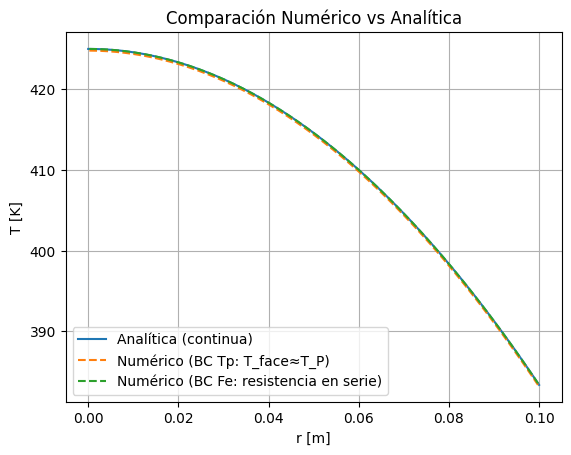

In [29]:
# --- Comparación Numérico vs Analítica (ambas BC) ---
import numpy as np
import matplotlib.pyplot as plt

# Parámetros físicos
Re, lam, qdot, alpha_G, T_G = 0.10, 20.0, 5.0e5, 200.0, 300.0
A_s = 4.0*np.pi*Re**2

def T_ana(r):
    # Solución analítica (Robin real en r=Re)
    return T_G + (qdot/(3.0*alpha_G))*Re + (qdot/(6.0*lam))*(Re**2 - r**2)

def solve_FVM(N, bc_type="Tp", omega=1.7, tol=1e-12, itmax=200000):
    # Mallado
    r_f = np.linspace(0.0, Re, N+1)
    r_c = 0.5*(r_f[:-1] + r_f[1:])
    Aw  = 4.0*np.pi*(r_f[:-1]**2)
    Ae  = 4.0*np.pi*(r_f[1:]**2)
    Vp  = (4.0*np.pi/3.0)*(r_f[1:]**3 - r_f[:-1]**3)
    dWP = np.zeros(N); dPE = np.zeros(N)
    dWP[1:]  = r_c[1:] - r_c[:-1]   # rP - rW (centro-centro)
    dPE[:-1] = r_c[1:] - r_c[:-1]   # rE - rP (centro-centro)

    aW = np.zeros(N); aE = np.zeros(N); aP = np.zeros(N); bP = np.zeros(N)
    SU = qdot * Vp

    for i in range(N):
        Dw = 0.0 if i==0 else lam*Aw[i]/(dWP[i] + 1e-300)
        if i == N-1:
            if bc_type == "Tp":
                H = alpha_G * A_s
                aW[i]=Dw; aE[i]=0.0; aP[i]=Dw+H; bP[i]=SU[i] + H*T_G
            elif bc_type == "Fe":
                delta = r_f[-1] - r_c[-1]               # centroide -> superficie
                Fe = A_s / ( (1.0/alpha_G) + (delta/(lam + 1e-300)) )
                aW[i]=Dw; aE[i]=0.0; aP[i]=Dw+Fe; bP[i]=SU[i] + Fe*T_G
            else:
                raise ValueError("bc_type debe ser 'Tp' o 'Fe'")
        else:
            De = lam*Ae[i]/(dPE[i] + 1e-300)
            aW[i]=Dw; aE[i]=De; aP[i]=Dw+De; bP[i]=SU[i]

    def gs(aW,aP,aE,bP,T0,omega,tol,itmax):
        T=T0.copy(); N=len(T)
        for it in range(itmax):
            Told=T.copy()
            for j in range(N):
                TW=T[j-1] if j>0   else 0.0
                TE=T[j+1] if j<N-1 else 0.0
                RHS=aE[j]*TE + aW[j]*TW + bP[j]
                T[j]=(1.0-omega)*T[j] + omega*RHS/(aP[j]+1e-300)
            if np.max(np.abs(T - Told)) < tol:
                return T, it+1
        return T, itmax

    T0 = np.full(N, T_G)
    Tn, iters = gs(aW,aP,aE,bP,T0,omega,tol,itmax)
    return r_c, r_f, Tn, iters

# --- Ejecuta con una malla dada ---
N = 200
r_c_Tp, r_f_Tp, T_Tp, it_Tp = solve_FVM(N, bc_type="Tp", omega=1.75)
r_c_Fe, r_f_Fe, T_Fe, it_Fe = solve_FVM(N, bc_type="Fe", omega=1.6)

# Analítica en centros de cada malla (coinciden aquí porque N es el mismo)
T_ref = T_ana(r_c_Tp)

# Errores en centros
Linf_Tp = np.max(np.abs(T_Tp - T_ref))
Linf_Fe = np.max(np.abs(T_Fe - T_ref))
print(f"N={N} | L_inf (BC Tp) = {Linf_Tp:.3e} K | L_inf (BC Fe) = {Linf_Fe:.3e} K")

# --- Gráfica comparación ---
r_plot = np.linspace(0.0, Re, 400)
plt.figure()
plt.plot(r_plot, T_ana(r_plot), '-', label='Analítica (continua)')
plt.plot(r_c_Tp, T_Tp, '--',  label='Numérico (BC Tp: T_face≈T_P)')
plt.plot(r_c_Fe, T_Fe, '--', label='Numérico (BC Fe: resistencia en serie)')
plt.xlabel('r [m]'); plt.ylabel('T [K]')
plt.title('Comparación Numérico vs Analítica')
plt.grid(True); plt.legend()
plt.show()
